In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [21]:
train_df = pd.read_csv('train.csv')
train = train_df.copy()
test = pd.read_csv('test.csv')
cat_cols  = ['University Rating', 'Research', 'First_Generation']
count_cols  = ['GRE Score', 'TOEFL Score', 'SOP',  'CGPA', 'Age']
train[cat_cols] = train[cat_cols].astype('category')
print(train.isna().sum())

ID                     0
GRE Score            360
TOEFL Score          360
University Rating      0
SOP                  360
LOR                    0
CGPA                 360
Research               0
Admitted               0
Age                    0
Location               0
First_Generation       0
dtype: int64


In [22]:
train.rename(columns = {'LOR ': 'LOR'}, inplace=True)
missing_cols = ['GRE Score', 'TOEFL Score', 'SOP', 'CGPA']

#Fill in missing values since they are up to 10% of our dataset
train[missing_cols] = train[missing_cols].fillna(train[missing_cols].median())
print(train.isna().sum())

ID                   0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Admitted             0
Age                  0
Location             0
First_Generation     0
dtype: int64


### We have a class imbalance in our target variable in our dataset as shown in the barchart below

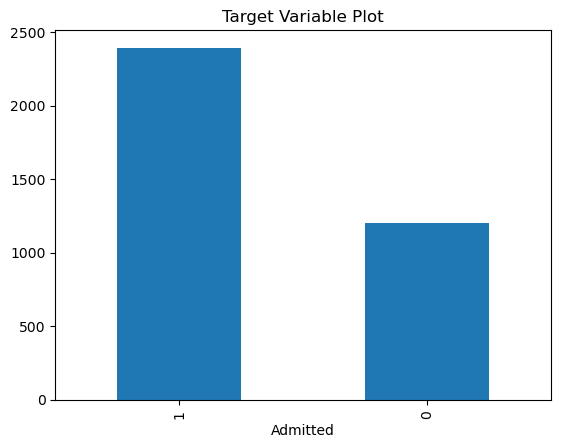

In [23]:
train['Admitted'].value_counts().plot(kind='bar')
plt.title('Target Variable Plot');

In [24]:
train[cat_cols]

,University Rating,Research,First_Generation
0,4,1,1
1,5,1,1
2,4,1,0
3,3,0,1
4,3,1,1
...,...,...,...
3595,2,1,0
3596,4,1,0
3597,4,1,0
3598,5,1,1


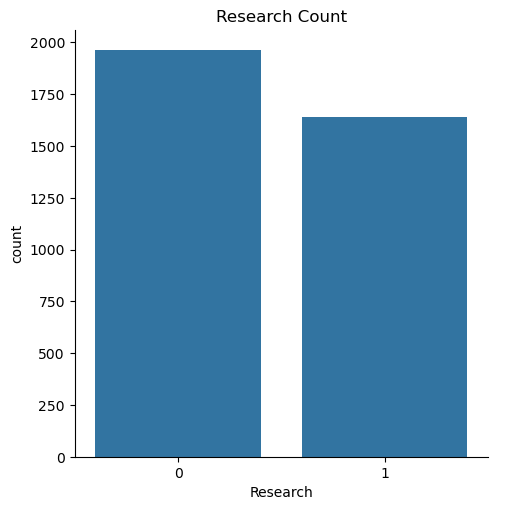

In [25]:
sns.catplot(train[cat_cols], x='Research', kind='count')
plt.title('Research Count');

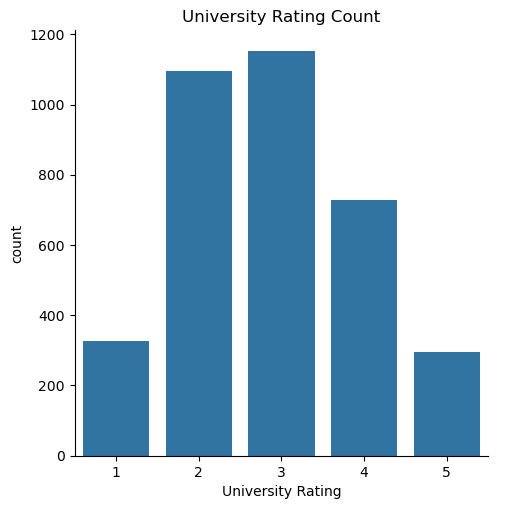

In [26]:
sns.catplot(train[cat_cols], x='University Rating', kind='count')
plt.title('University Rating Count');

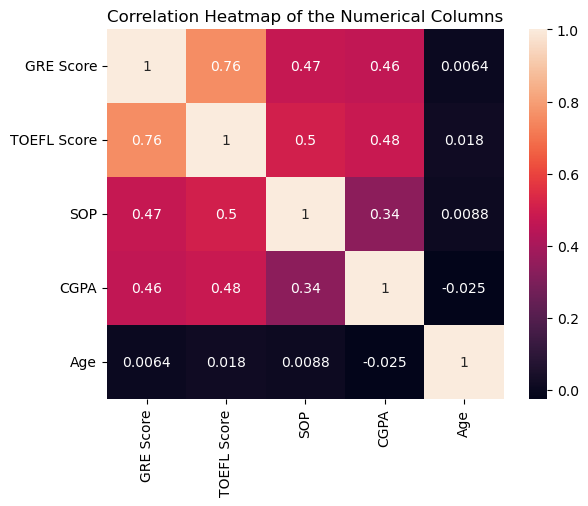

In [27]:
sns.heatmap(train[count_cols].corr(), annot=True)
plt.title('Correlation Heatmap of the Numerical Columns');

In [28]:
train.columns

Index(['ID', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR',
       'CGPA', 'Research', 'Admitted', 'Age', 'Location', 'First_Generation'],
      dtype='object')

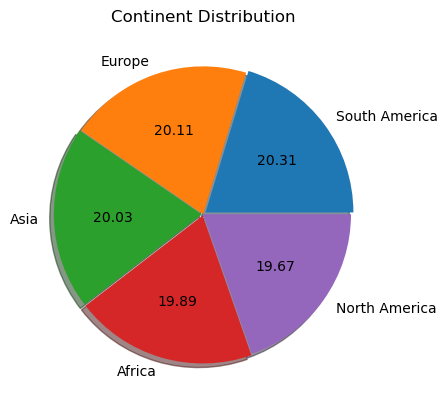

In [29]:

lo = train['Location'].value_counts()
plt.pie(lo.values, labels = lo.index, autopct='%.2f', explode=[0.02, .0, .01, .01, .0],shadow=True )
plt.title('Continent Distribution');
# lo.values

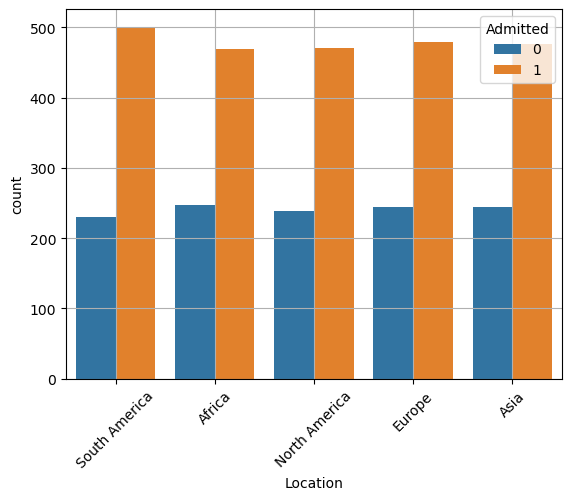

In [103]:
sns.countplot(train, x='Location', hue='Admitted')
plt.xticks(rotation=45)
plt.grid(True);

Text(0.5, 1.0, 'TOEEFL Scores per Continent')

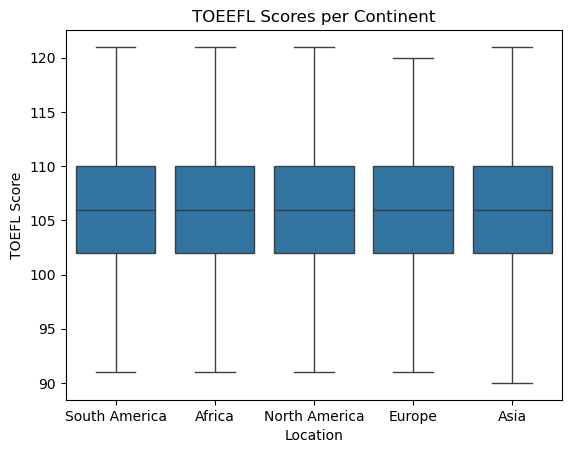

In [31]:
sns.boxplot(train, y='TOEFL Score', x='Location') 
plt.title('TOEEFL Scores per Continent')

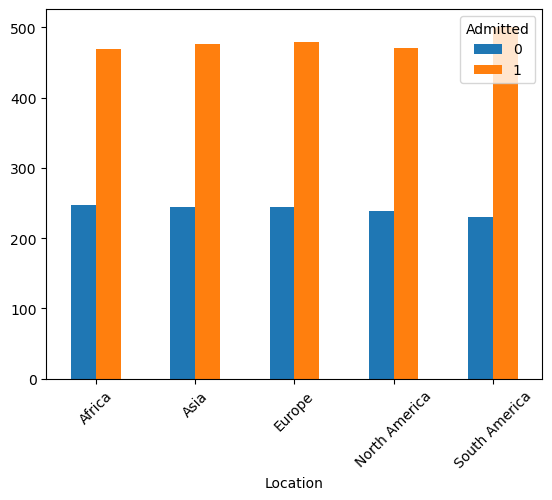

In [32]:
prop_df = train.groupby(['Location', 'Admitted']).size().unstack(fill_value=0)
# prop_df.plot(kind='bar')
prop_df.plot(kind='bar', rot=45);

<Axes: xlabel='Admitted', ylabel='Location'>

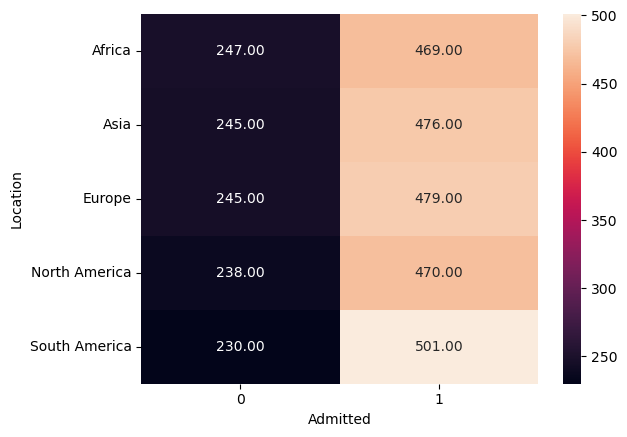

In [33]:
sns.heatmap(prop_df, annot=True, fmt='.2f')

In [34]:
prop_df['zeros_ratio'] = prop_df[0] / prop_df.sum(axis=1)
prop_df['ones_ratio'] = prop_df[1]/ prop_df.sum(axis=1)
prop_df

Admitted,0,1,zeros_ratio,ones_ratio
Location,,,,
Africa,247,469,0.344972,0.654712
Asia,245,476,0.339806,0.659883
Europe,245,479,0.338398,0.661293
North America,238,470,0.336158,0.663527
South America,230,501,0.314637,0.685068


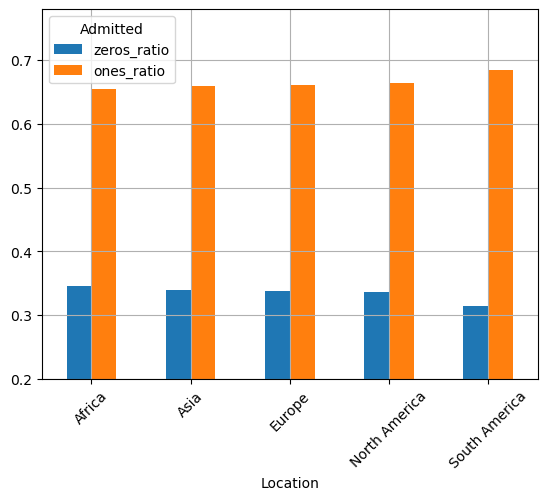

In [102]:
prop_df[['zeros_ratio', 'ones_ratio']].plot(kind='bar', rot=45)
plt.ylim(.2,.78)
plt.grid(True);

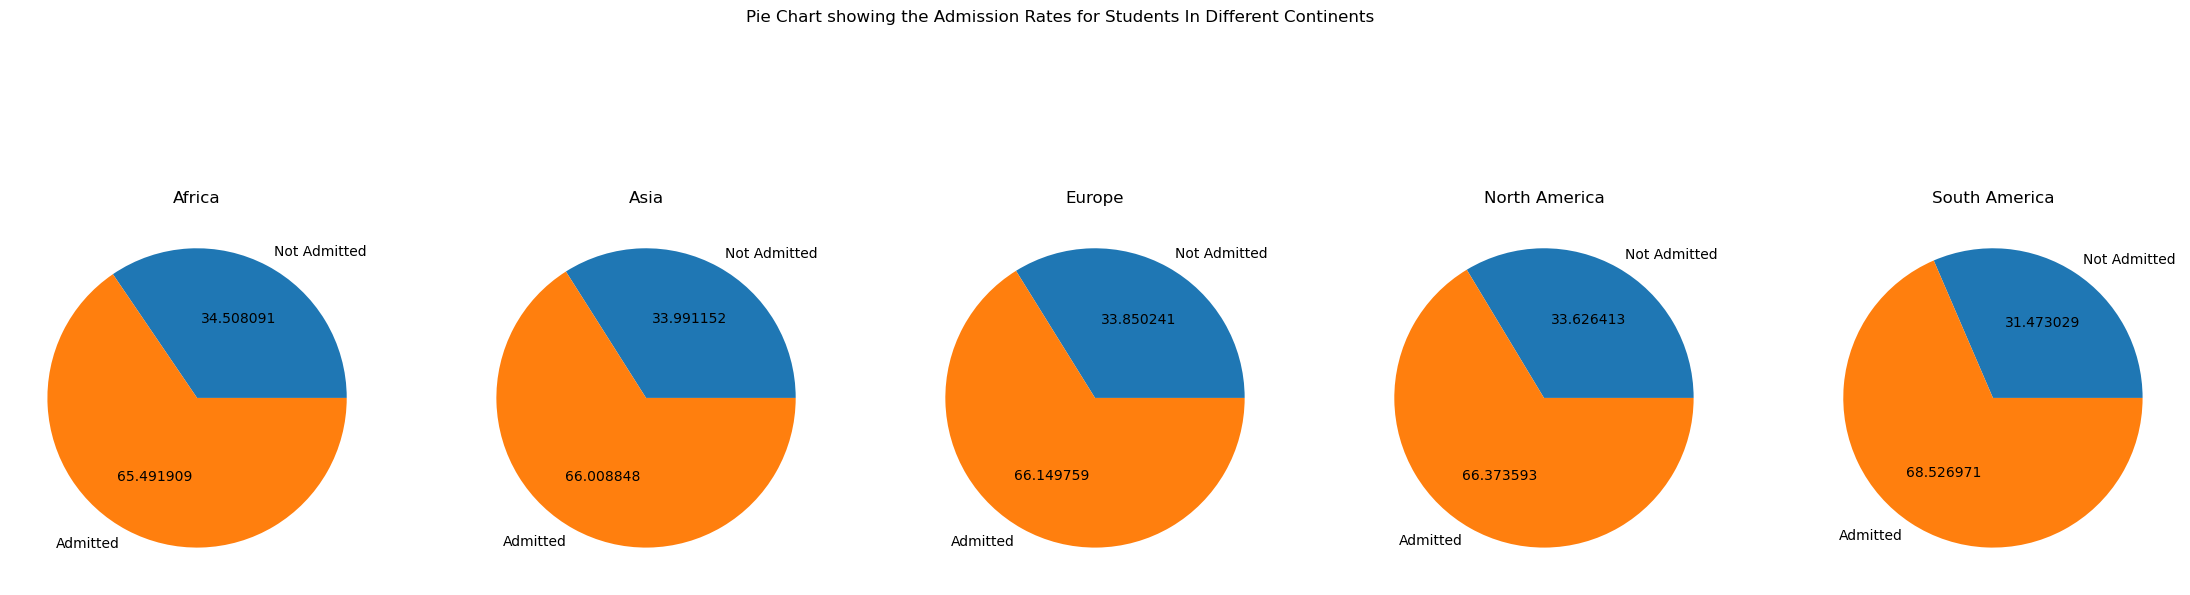

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=len(prop_df), figsize=(28,8))

#Loop through ax and the prop_df dataframe to obtain pie charts for each continent
for axis, (i, j) in zip(ax, prop_df.iterrows()):
    axis.pie([j['zeros_ratio'], j['ones_ratio']], labels=['Not Admitted','Admitted'], autopct='%f')
    axis.set_title(i)
    plt.suptitle('Pie Chart showing the Admission Rates for Students In Different Continents')
    # plt.tight_layout()

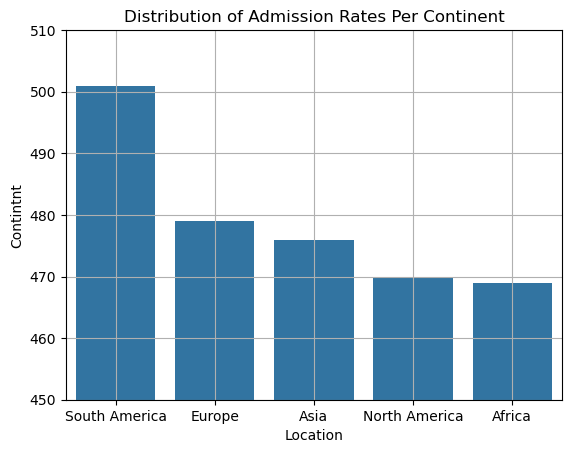

In [101]:
sns.barplot(prop_df[1].sort_values(ascending=False))
plt.ylim(450, 510)
plt.title('Distribution of Admission Rates Per Continent')
plt.ylabel('Contintnt')
plt.grid(True);

C:\Users\hp\AppData\Local\Temp\ipykernel_8184\1201566536.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(['Location', 'University Rating']).size().unstack().plot(kind='bar', rot=45)


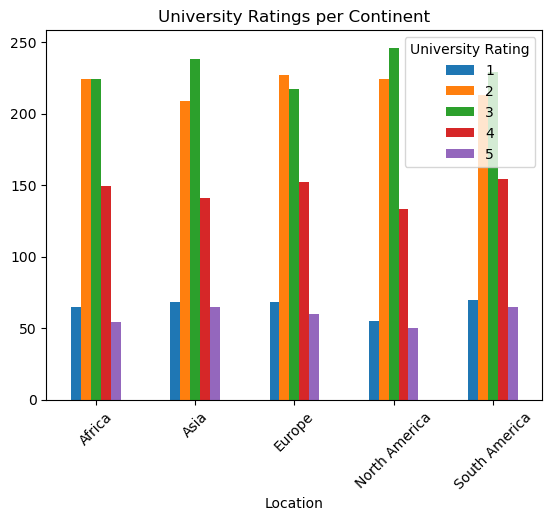

In [42]:
train.groupby(['Location', 'University Rating']).size().unstack().plot(kind='bar', rot=45)
plt.title('University Ratings per Continent');

### The dataset is split into train and test sets, also we account for the class imbalance in the target variable by using stratify while splitting the data.

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier,\
                                RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
X = train.drop(['Admitted', 'ID'], axis=1)
X = pd.get_dummies(X, columns=['Location'], drop_first=True)
y = train['Admitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

grad_clf = GradientBoostingClassifier()
cv = cross_val_score(grad_clf,  X, y)
print(f'Average CV Score: {np.mean(cv)}')

Average CV Score: 0.858611111111111


Accuracy Score for Gradient Boost: 0.8601851851851852


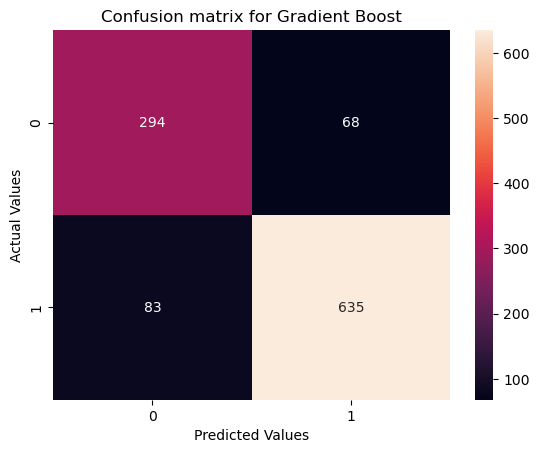

In [69]:
grad_clf.fit(X_train, y_train)
grad_preds = grad_clf.predict(X_test)
print(f'Accuracy Score for Gradient Boost: {accuracy_score(y_test, grad_preds)}')
sns.heatmap(confusion_matrix(y_test, grad_preds), annot=True, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');
plt.title('Confusion matrix for Gradient Boost');

Accuracy Score for Gradient Boost: 0.8592592592592593


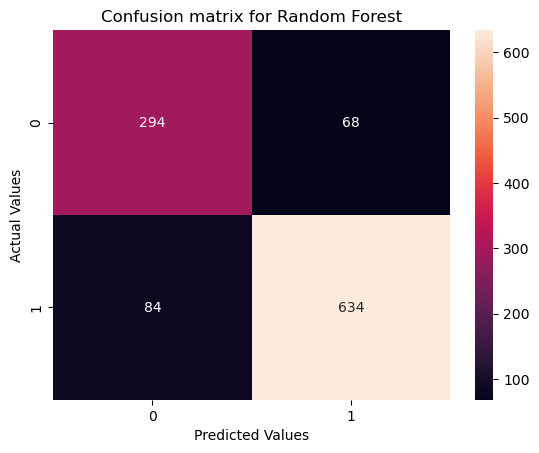

In [70]:
random_clf = RandomForestClassifier(200, max_depth=7)
random_clf.fit(X_train, y_train)
random_preds = random_clf.predict(X_test)
print(f'Accuracy Score for Random Forest: {accuracy_score(y_test, random_preds)}')
sns.heatmap(confusion_matrix(y_test, random_preds), annot=True, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');
plt.title('Confusion matrix for Random Forest');

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score for Ada Boost: 0.8444444444444444


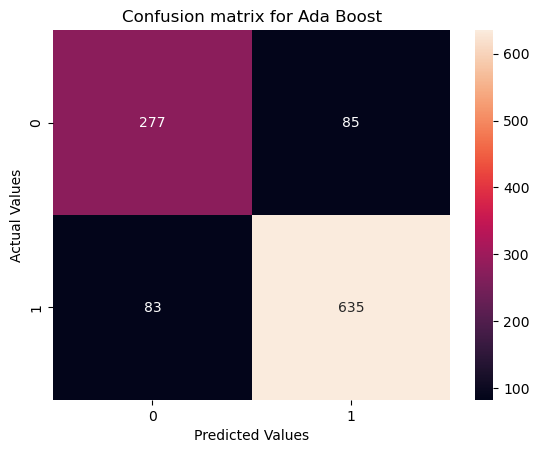

In [72]:
ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, y_train)
ada_preds = ada_clf.predict(X_test)
print(f'Accuracy Score for Ada Boost: {accuracy_score(y_test, ada_preds)}')
sns.heatmap(confusion_matrix(y_test, ada_preds), annot=True, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values');
plt.title('Confusion matrix for Ada Boost');

In [73]:
clfs = [('GradientBoostingClassifier', GradientBoostingClassifier()),\
               ('AdaBoostClassifier', AdaBoostClassifier()),\
               ('RandomForestClassifier', RandomForestClassifier())]
vc = VotingClassifier(clfs)
vc.fit(X_train, y_train)
vc_preds = vc.predict(X_test)
print(f'Accuracy Score of Voting Classifers: {accuracy_score(y_test, vc_preds)}')
# voter.fit(X_train, y_train)
# voter.preduict

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score of Voting Classifers: 0.8592592592592593


In [48]:
for clf_name, clf in clfs:
    clf.fit(X_train, y_train)
    print(f'{clf_name}: {accuracy_score(y_test, clf.predict(X_test))}')

GradientBoostingClassifier: 0.85


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier: 0.8342592592592593
RandomForestClassifier: 0.8518518518518519


#### From our barplots below, we can see that `GRE Score` is the most important feature for determining whether students gain Admission.

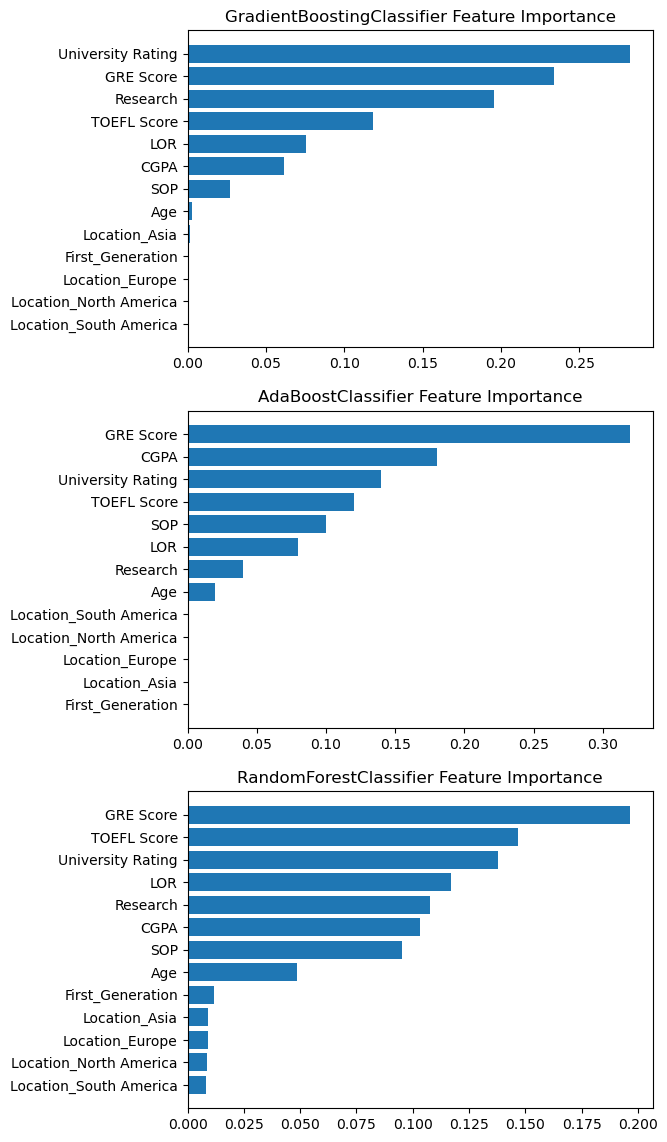

In [49]:
fig, ax = plt.subplots(ncols=1, nrows=len(clfs), figsize=(6, 14))
for axis, (clf_name, clf) in zip(ax, clfs):
    clf_df = pd.DataFrame({'Feature':X.columns, 'Score': clf.feature_importances_}).sort_values('Score', ascending=True)
    axis.barh(width=clf_df.Score, y=clf_df.Feature)
    axis.set_title(clf_name+' Feature Importance')

#### The roc curve shows that the gradient boost model has great prediction power as it tends more to the top left corner.
##### Also, a `roc_auc_score` of 0.94 shows that our model has great discretionaery power.

ROC AUC SCORE: 0.9426045337724496


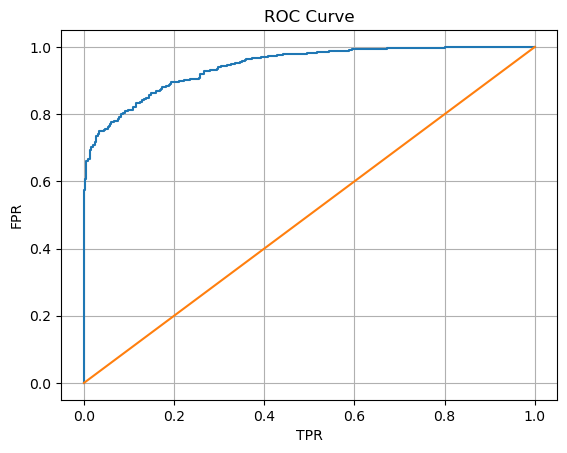

In [117]:
from sklearn.metrics import roc_curve, roc_auc_score
grad_preds_proba = grad_clf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, grad_preds_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0,1])
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.title('ROC Curve')
plt.grid(True)
print(f'ROC AUC SCORE: {roc_auc_score(y_test, grad_preds_proba)}');